In [1]:
from mvlearn.embed.kcca_experimental import KCCA as KCCA2
from mvlearn.embed.kcca import KCCA as KCCA
from mvlearn.embed.dcca import DCCA
from mvlearn.embed.gcca import GCCA
%load_ext autoreload
%autoreload 2

import numpy as np
import collections
import matplotlib.pyplot as plt
from graspy.plot import pairplot
%matplotlib inline
import seaborn as sns

from rkcca import *
from rkcca import kcca as rkcca

In [5]:
def make_data(kernel, N, seeds=[None]*4):
    ## Define two latent variables (number of samples x 1)
    np.random.seed(seeds[0])
    latvar1 = np.random.randn(N,)
    np.random.seed(seeds[1])
    latvar2 = np.random.randn(N,)
    
    ## Define independent components for each dataset (number of observations x dataset dimensions)
    np.random.seed(seeds[2])
    indep1 = np.random.randn(N, 4)
    np.random.seed(seeds[3])
    indep2 = np.random.randn(N, 5)
    #indep2 = np.random.randn(N, 4)
    
    if kernel == "linear":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        #x = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, 0*latvar1, 0*latvar2)).T
        #y = 0.25*indep2 + -0.75*np.vstack((latvar1, latvar2, 0*latvar1, 0*latvar2)).T
        
        return [x,y]
    
    elif kernel == "poly":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1**2, latvar2**2, latvar1**2, latvar2**2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        #x = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, 0*latvar1, 0*latvar2)).T
        #y = 0.25*indep1 + 0.75*np.vstack((latvar1**2, latvar2**2, 0*latvar1**2, 0*latvar2**2)).T
        
        return [x,y]
    
    elif kernel == "gaussian":
        np.random.seed(seeds[0])
        t = np.random.uniform(-np.pi, np.pi, N)
        np.random.seed(seeds[1])
        e1 = np.random.normal(0, 0.05, (N,2))
        np.random.seed(seeds[2])
        e2 = np.random.normal(0, 0.05, (N,2))
        
        x = np.zeros((N,2))
        x[:,0] = t
        x[:,1] = np.sin(3*t)
        x += e1
        
        y = np.zeros((N,2))
        y[:,0] = np.exp(t/4)*np.cos(2*t)
        y[:,1] = np.exp(t/4)*np.sin(2*t)
        y += e2
        
        return [x,y]

In [16]:
def plot_components(components, method, transformation, labels=None):
    # We plot dimensions of both views to further show that the first two dimensions are linearly correlated ideally
    n_dim = components[0].shape[1]
    fig,axes = plt.subplots(n_dim,n_dim,figsize=(8,8))
    for i,ax in enumerate(axes.flatten()):
        dim2 = int(i/n_dim)
        dim1 = i % n_dim
        if not labels is None:
            ax.scatter(components[0][:,dim1],components[1][:,dim2], c=labels, alpha=0.2)
        else:
            ax.scatter(components[0][:,dim1],components[1][:,dim2])
        if dim2 == n_dim-1:
            ax.set_xlabel(f'View 1 Component {dim1+1}')
        if dim1 == 0:
            ax.set_ylabel(f'View 2 Component {dim2+1}')
        ax.axis('equal')
        #ax.set_xticks([])

    #plt.suptitle(f'{method} o {transformation} Transform')
    if method is not None:
        plt.savefig(f'./{method}_{transformation}_data.png',dpi=300,format='png')
    plt.show()
    
def compare_transforms(function, n = 200, save_name = None):
    data_transforms = ['linear', 'poly', 'gaussian']
    for transform in data_transforms:
        Xs_train = make_data(transform, n, seeds=[1,2,3,4])
        if function=='raw':
            plot_components(Xs_train, None, transform)
        else:
            Xs_test = make_data(transform, n, seeds=[5,6,7,8])
            components = function.fit(Xs_train).transform(Xs_test)
            plot_components(components, save_name, transform)

## Plot Transforms

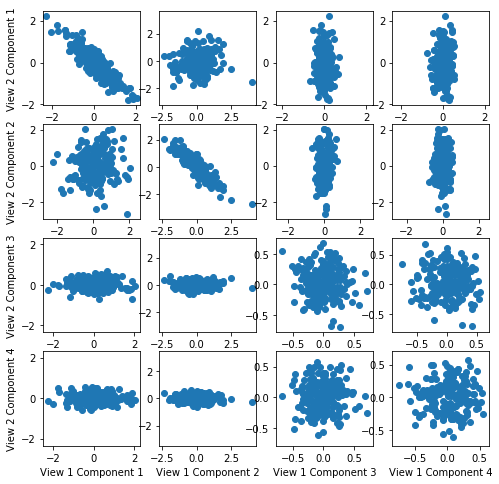

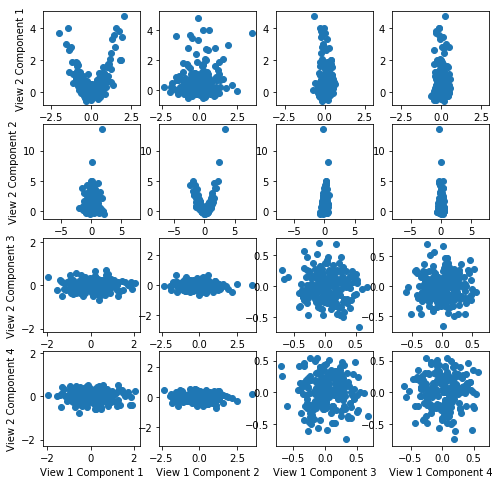

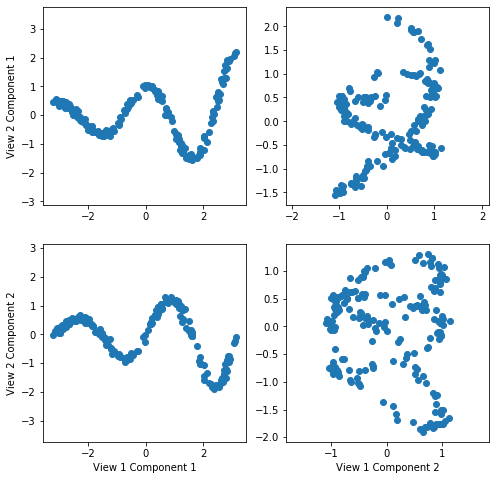

In [21]:
compare_transforms('raw')

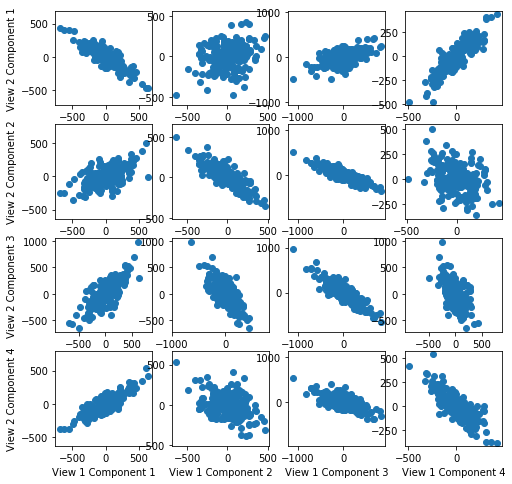

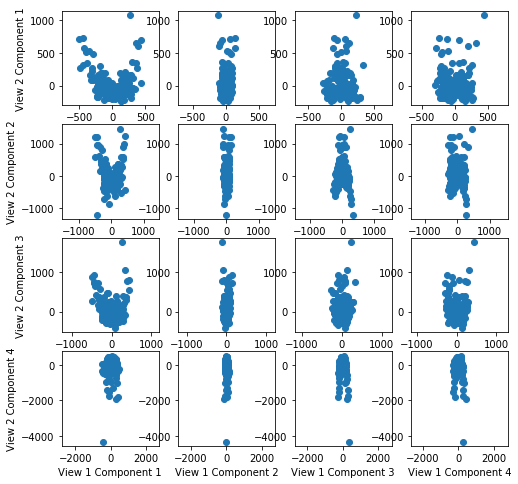

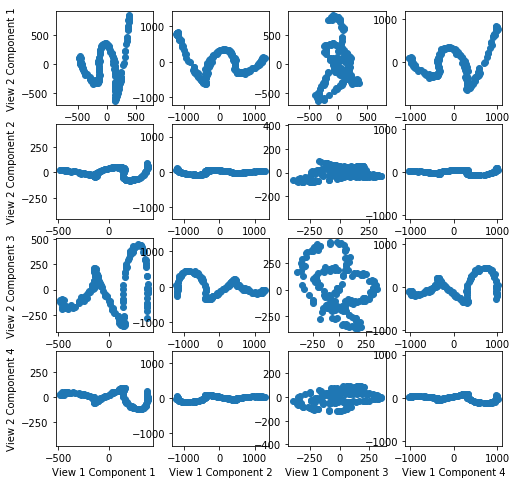

In [22]:
# kcca_l = KCCA(ktype ="linear", constant = 100.0, n_components = 4)
# linearkcca = kcca_l.fit_transform(Xs)
kcca = KCCA(ktype ="poly", constant = 100.0, degree = 2.0, n_components = 4)
compare_transforms(kcca)

In [34]:
Xs_train = make_data('poly', 200, seeds=[1,2,3,4])
Xs_test = make_data('poly', 200, seeds=[5,6,7,8])

kcca = KCCA(ktype ="poly", constant = 100.0, degree = 2.0, n_components = 4)
components = kcca.fit(Xs_train).transform(Xs_train)

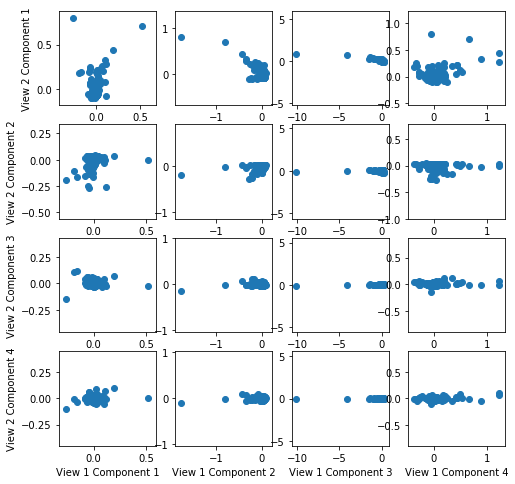

In [35]:
plot_components(components, None, None)

## Compare two implementations

In [6]:
Xs_train = make_data('linear', 200, seeds=[1,2,3,4])
Xs_test = make_data('linear', 200, seeds=[5,6,7,8])

In [59]:
ktype = 'linear'
degree = 2.0
n_components = 4
sigma = 1.0
reg = 0.001

In [68]:
kcca = KCCA(ktype=ktype, constant = 0.0, degree = degree, n_components = n_components, sigma=sigma, reg=reg)
kcca = kcca.fit(Xs_train)

In [69]:
kcca2 = KCCA2(ktype=ktype, constant = 0.0, degree = degree, n_components = n_components, sigma=sigma, reg=reg)
kcca2 = kcca2.fit(Xs_train)

In [70]:
components = rkcca(Xs_train, reg=reg, numCC=n_components, kernelcca=True, ktype=ktype, gausigma=sigma, degree=degree)

(array([ 5.,  8.,  7., 35., 26., 46., 33., 21., 14.,  5.]),
 array([-0.18911991, -0.15338769, -0.11765546, -0.08192323, -0.046191  ,
        -0.01045878,  0.02527345,  0.06100568,  0.09673791,  0.13247013,
         0.16820236]),
 <a list of 10 Patch objects>)

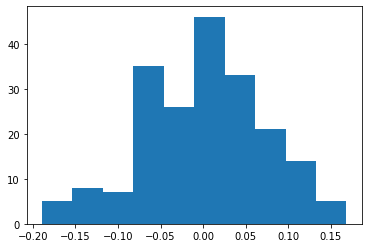

In [71]:
plt.hist((kcca.weights_[0][:,0] - components[0][:,0]).flatten())

(array([ 4., 12., 16., 22., 37., 37., 32., 22., 14.,  4.]),
 array([-0.17861511, -0.14419078, -0.10976645, -0.07534212, -0.0409178 ,
        -0.00649347,  0.02793086,  0.06235518,  0.09677951,  0.13120384,
         0.16562816]),
 <a list of 10 Patch objects>)

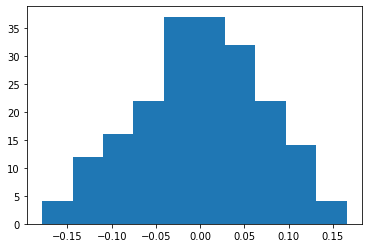

In [72]:
plt.hist((kcca2.weights_[0][:,0] - components[0][:,0]).flatten())

(array([ 3.,  4., 23., 24., 54., 35., 38., 13.,  3.,  3.]),
 array([-0.06782843, -0.05407272, -0.04031702, -0.02656131, -0.0128056 ,
         0.0009501 ,  0.01470581,  0.02846152,  0.04221722,  0.05597293,
         0.06972864]),
 <a list of 10 Patch objects>)

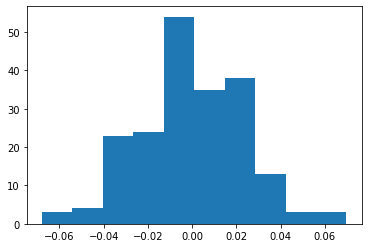

In [74]:
plt.hist((kcca.weights_[0][:,0] - kcca2.weights_[0][:,0]).flatten())

In [58]:
d = np.array([[1,2],[3,4]])
print(d)
print(d.mean(0))

[[1 2]
 [3 4]]
[2. 3.]
